MovieLens 1M movie ratings. Stable benchmark dataset. 1 million ratings from 6000 users on 4000 movies. Released 2/2003.

- [README.txt](https://files.grouplens.org/datasets/movielens/ml-1m-README.txt)
- [ml-1m.zip](https://files.grouplens.org/datasets/movielens/ml-1m.zip) (size: 6 MB)

Permalink: https://grouplens.org/datasets/movielens/1m/

In [117]:
#@title Импорт библиотек {display-mode:"form"}
from IPython.display import display, clear_output, Markdown
import numpy as np
import pandas as pd
import datetime
import scipy.sparse as sp
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from itertools import islice, cycle
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
from more_itertools import pairwise
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

!pip install -q icecream
from icecream import ic
!pip install -q implicit --upgrade
from implicit.nearest_neighbours import CosineRecommender, BM25Recommender, TFIDFRecommender

from google.colab import drive
drive.mount('/content/drive')

working_dir = '/content/drive/MyDrive/Study/7/Машинное обучение/ЛР1_Кластеризация/'

def md(fstring):
  display(Markdown(fstring))

pd.options.mode.chained_assignment = None

import warnings
warnings.filterwarnings("ignore")

def num_bytes_format(num_bytes, float_prec=4):
    units = ['bytes', 'Kb', 'Mb', 'Gb', 'Tb', 'Pb', 'Eb']
    for unit in units[:-1]:
        if abs(num_bytes) < 1000:
            return f'{num_bytes:.{float_prec}f} {unit}'
        num_bytes /= 1000
    return f'{num_bytes:.4f} {units[-1]}'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [118]:
movies = pd.read_csv('/content/drive/MyDrive/Study/7/Машинное обучение/ЛР2_Рекомендательные_системы/movies.dat', encoding='latin1', sep='::', names=['MovieID', 'Title', 'Genres'])
ratings = pd.read_csv('/content/drive/MyDrive/Study/7/Машинное обучение/ЛР2_Рекомендательные_системы/ratings.dat', encoding='latin1', sep='::', names=['UserID', 'MovieID', 'Rating', 'Timestamp'])
users = pd.read_csv('/content/drive/MyDrive/Study/7/Машинное обучение/ЛР2_Рекомендательные_системы/users.dat', encoding='latin1', sep='::', names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'])

In [119]:
movies

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


In [120]:
ratings

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


In [121]:
users

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455
...,...,...,...,...,...
6035,6036,F,25,15,32603
6036,6037,F,45,1,76006
6037,6038,F,56,1,14706
6038,6039,F,45,0,01060


In [122]:
#@title Функции графиков {display-mode:"form"}
import math
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    # nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    nGraphRow = math.ceil(nCol / nGraphPerRow)
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

# Correlation matrix
def plotCorrelationMatrix(df, graphWidth: int, name: str):
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {name}', fontsize=15)
    plt.show()

# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    # plt.show()

def allInOnePlots(df, perColumnNGraphShown: int, perColumnNGraphPerRow: int, correlationMatrixWidth: int, correlationMatrixName: str, scatterMatrixPlotSize, scatterMatrixTextSize):
  plotPerColumnDistribution(df, perColumnNGraphShown, perColumnNGraphPerRow)
  plotCorrelationMatrix(df, correlationMatrixWidth, correlationMatrixName)
  plotScatterMatrix(df, scatterMatrixPlotSize, scatterMatrixTextSize)


# Графики

In [123]:
# allInOnePlots(df=ratings, perColumnNGraphShown=8, perColumnNGraphPerRow=1, correlationMatrixWidth=8, correlationMatrixName='ratings', scatterMatrixPlotSize=5, scatterMatrixTextSize=10)

In [124]:
# allInOnePlots(df=movies, perColumnNGraphShown=8, perColumnNGraphPerRow=1, correlationMatrixWidth=8, correlationMatrixName='movies', scatterMatrixPlotSize=5, scatterMatrixTextSize=10)

In [125]:
# allInOnePlots(df=users, perColumnNGraphShown=8, perColumnNGraphPerRow=1, correlationMatrixWidth=8, correlationMatrixName='users', scatterMatrixPlotSize=5, scatterMatrixTextSize=10)

# Ход работы

## Небольшая работа с датасетом

In [126]:
#@title Объединение всех таблиц в одну {display-mode:"form"}
_df1 = pd.merge(users, ratings, on='UserID')
_df2 = pd.merge(_df1, movies, on='MovieID')

df = _df2

df

,UserID,Gender,Age,Occupation,Zip-code,MovieID,Rating,Timestamp,Title,Genres
0,1,F,1,10,48067,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,M,56,16,70072,1193,5,978298413,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,M,25,12,32793,1193,4,978220179,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,M,25,7,22903,1193,4,978199279,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,M,50,1,95350,1193,5,978158471,One Flew Over the Cuckoo's Nest (1975),Drama
...,...,...,...,...,...,...,...,...,...,...
1000204,5949,M,18,17,47901,2198,5,958846401,Modulations (1998),Documentary
1000205,5675,M,35,14,30030,2703,3,976029116,Broken Vessels (1998),Drama
1000206,5780,M,18,17,92886,2845,1,958153068,White Boys (1999),Drama
1000207,5851,F,18,20,55410,3607,5,957756608,One Little Indian (1973),Comedy|Drama|Western


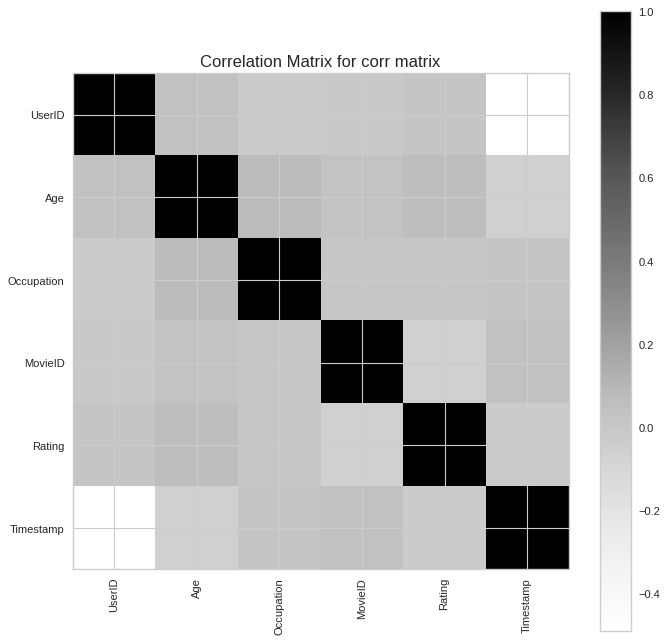

In [127]:
plotCorrelationMatrix(df=df, graphWidth=10, name='corr matrix')

In [147]:
#@title Дубликаты? {display-mode:"form"}
duplicates = df.duplicated(subset=['UserID', 'MovieID'], keep=False)
duplicates.sum()

0

In [129]:
df.nunique()

UserID          6040
Gender             2
Age                7
Occupation        21
Zip-code        3439
MovieID         3706
Rating             5
Timestamp     458455
Title           3706
Genres           301
dtype: int64

Результат показывает, что существует только 2 возможных значения для пола, 7 возможных значений для возраста, 21 возможное значение для профессии и 5 возможных значений для рейтинга.

## CategoryDType

CategoryDType - тип в pandas, который позволяет оптимизировать потребление памяти для строковых столбцов и задать логический порядок для значений в них.

In [130]:
_df4 = pd.DataFrame()
_df4['Gender'] = df['Gender'].astype('category').copy()
_df4

,Gender
0,F
1,M
2,M
3,M
4,M
...,...
1000204,M
1000205,M
1000206,M
1000207,F


In [131]:
_df4['GenderCodes'] = _df4['Gender'].cat.codes
_df4

,Gender,GenderCodes
0,F,0
1,M,1
2,M,1
3,M,1
4,M,1
...,...,...
1000204,M,1
1000205,M,1
1000206,M,1
1000207,F,0


In [132]:
mapping = dict(enumerate(_df4['Gender'].cat.categories))
mapping

{0: 'F', 1: 'M'}

In [133]:
df_user_item = df[['UserID', 'MovieID']].copy()

In [134]:
num_bytes_ints = df_user_item.memory_usage(deep=True).sum()
num_bytes_format(num_bytes_ints)

'24.0050 Mb'

In [135]:
df_user_item = df_user_item.astype('string')
num_bytes_str = df_user_item.memory_usage(deep=True).sum()
num_bytes_format(num_bytes_str)

'129.5781 Mb'

In [136]:
df_user_item = df_user_item.astype('category')
num_bytes_cat = df_user_item.memory_usage(deep=True).sum()
num_bytes_format(num_bytes_cat)

'12.8591 Mb'

In [137]:
print(f'Экономия category относительно string: {(1 - num_bytes_cat / num_bytes_str) * 100:.2f}%')
print(f'Экономия ints относительно category: {(1 - num_bytes_ints / num_bytes_cat) * 100:.2f}%')

Экономия category относительно string: 90.08%
Экономия ints относительно category: -86.68%


In [138]:
df_user_item = df_user_item.astype(np.int64).astype('category')
num_bytes_int_cat = df_user_item.memory_usage(deep=True).sum()
num_bytes_format(num_bytes_int_cat)

'12.3447 Mb'

In [139]:
print(f'Экономия category on int64 относительно category on string: {(1 - num_bytes_int_cat / num_bytes_cat) * 100:.2f}%')

Экономия category on int64 относительно category on string: 4.00%


In [140]:
df_user_item['UserID'].cat.codes.dtype

dtype('int16')

## IntegerDType

IntegerDType - группа типов в pandas, который позволяет целочисленным столбцам содержать пропущенные значения.

Для классического целочисленного типа есть свой "двойник". Отличаются только первыми заглавными буквами, например:

- numpy.int32 - pd.Int32DType
- numpy.uint32 - pd.UInt64DType

Этот тип стоит использовать только для экономии памяти при хранении датафрейма или при простых операциях на ним. Большинство библиотек этот тип в данный момент не поддерживают.

In [141]:
ratings = df['Rating'].astype(np.float32).copy()

In [142]:
num_bytes_float = ratings.memory_usage(deep=True)
num_bytes_format(num_bytes_float)

'12.0025 Mb'

In [144]:
ratings = ratings.astype(pd.Int32Dtype())
num_bytes_Int32 = ratings.memory_usage(deep=True)
num_bytes_format(num_bytes_Int32)

ic| num_bytes_Int32: 13002717


'13.0027 Mb'

In [38]:
ratings = ratings.astype(pd.Int8Dtype())
num_bytes_Int8 = ratings.memory_usage(deep=True)
num_bytes_format(num_bytes_Int8)

'10.0021 Mb'

In [39]:
ratings

0          5
1          5
2          4
3          4
4          5
          ..
1000204    5
1000205    3
1000206    1
1000207    5
1000208    4
Name: Rating, Length: 1000209, dtype: Int8

In [40]:
print(f'Экономия Int8DType относительно float64: {(1 - num_bytes_Int8 / num_bytes_float) * 100:.2f}%')

Экономия Int8DType относительно float64: 16.67%


## Sparse Type

Sparse Type - тип данных в pandas для работы с разреженными данными.

Идея проста - храним только "известные" значения, остальное не храним и имитируем константой.

Сам тип создается на основе двух значений:

- dtype - тип сохраняемых значений
- fill_value - константа для пропущенных значений

In [41]:
sparse_type = pd.SparseDtype(np.float32, np.nan)
ratings = ratings.astype(np.float32).astype(sparse_type)

In [42]:
ratings

0          5.0
1          5.0
2          4.0
3          4.0
4          5.0
          ... 
1000204    5.0
1000205    3.0
1000206    1.0
1000207    5.0
1000208    4.0
Name: Rating, Length: 1000209, dtype: Sparse[float32, nan]

In [43]:
num_bytes_sparse = ratings.memory_usage(deep=True)
num_bytes_format(num_bytes_sparse)

'16.0033 Mb'

In [44]:
print(f'Экономия sparse относительно Int8DType: {(1 - num_bytes_sparse / num_bytes_Int8) * 100:.2f}%')
print(f'Экономия sparse относительно float32: {(1 - num_bytes_sparse / num_bytes_float) * 100:.2f}%')

Экономия sparse относительно Int8DType: -60.00%
Экономия sparse относительно float32: -33.33%


In [45]:
ratings.sparse.density

1.0

In [46]:
df.head()

,UserID,Gender,Age,Occupation,Zip-code,MovieID,Rating,Timestamp,Title,Genres
0,1,F,1,10,48067,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,M,56,16,70072,1193,5,978298413,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,M,25,12,32793,1193,4,978220179,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,M,25,7,22903,1193,4,978199279,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,M,50,1,95350,1193,5,978158471,One Flew Over the Cuckoo's Nest (1975),Drama


- users_mapping - конвертация ID в номер строки
- users_inv_mapping - номер строки в ID

In [47]:
users_inv_mapping = dict(enumerate(df['UserID'].unique()))
users_mapping = {v: k for k, v in users_inv_mapping.items()}
len(users_mapping)

6040

In [48]:
users_mapping[1], users_inv_mapping[0]

(0, 1)

In [49]:
items_inv_mapping = dict(enumerate(df['MovieID'].unique()))
items_mapping = {v: k for k, v in items_inv_mapping.items()}
len(items_mapping)

3706

In [50]:
items_mapping[1193], items_inv_mapping[0]

(0, 1193)

In [51]:
rows = df['UserID'].map(users_mapping.get)
cols = df['MovieID'].map(items_mapping.get)

rows.isna().sum(), cols.isna().sum()

(0, 0)

In [52]:
coo = sp.coo_matrix((
    np.ones(df.shape[0], dtype=np.int8),
    (rows, cols)
))
coo

<6040x3706 sparse matrix of type '<class 'numpy.int8'>'
	with 1000209 stored elements in COOrdinate format>

In [53]:
coo.todense()

matrix([[1, 1, 1, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

In [54]:
coo.row, coo.col, coo.data

(array([   0,    1,    2, ..., 4958, 1666, 4264], dtype=int32),
 array([   0,    0,    0, ..., 3703, 3704, 3705], dtype=int32),
 array([1, 1, 1, ..., 1, 1, 1], dtype=int8))

In [55]:
num_bytes_format(coo.data.nbytes + coo.row.nbytes + coo.col.nbytes)

'9.0019 Mb'

In [56]:
df['Weight'] = ((df['Occupation'] + 1) / 101) * (2 ** df['Rating'])
df['Weight'] = df['Weight'].astype(np.float32)

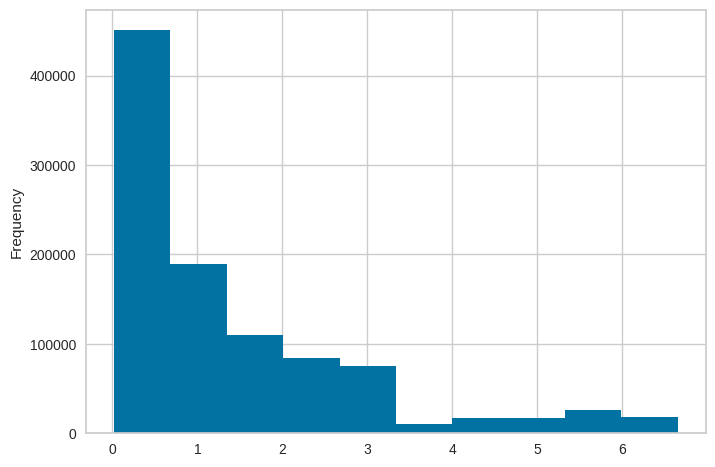

In [57]:
ax = df['Weight'].plot.hist()

In [58]:
coo = sp.coo_matrix((
    df['Weight'],
    (rows, cols)
))
coo

<6040x3706 sparse matrix of type '<class 'numpy.float32'>'
	with 1000209 stored elements in COOrdinate format>

In [59]:
num_bytes_format(coo.data.nbytes + coo.row.nbytes + coo.col.nbytes)

'12.0025 Mb'

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 0 to 1000208
Data columns (total 11 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   UserID      1000209 non-null  int64  
 1   Gender      1000209 non-null  object 
 2   Age         1000209 non-null  int64  
 3   Occupation  1000209 non-null  int64  
 4   Zip-code    1000209 non-null  object 
 5   MovieID     1000209 non-null  int64  
 6   Rating      1000209 non-null  int64  
 7   Timestamp   1000209 non-null  int64  
 8   Title       1000209 non-null  object 
 9   Genres      1000209 non-null  object 
 10  Weight      1000209 non-null  float32
dtypes: float32(1), int64(6), object(4)
memory usage: 87.8+ MB


In [61]:
df['GenderCodes'] = _df4['GenderCodes'].copy()

In [62]:
df['Age'] = df['Age'].astype('category')
df['GenderCodes'] = df['GenderCodes'].astype(pd.SparseDtype(np.float32, np.nan))

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 0 to 1000208
Data columns (total 12 columns):
 #   Column       Non-Null Count    Dtype               
---  ------       --------------    -----               
 0   UserID       1000209 non-null  int64               
 1   Gender       1000209 non-null  object              
 2   Age          1000209 non-null  category            
 3   Occupation   1000209 non-null  int64               
 4   Zip-code     1000209 non-null  object              
 5   MovieID      1000209 non-null  int64               
 6   Rating       1000209 non-null  int64               
 7   Timestamp    1000209 non-null  int64               
 8   Title        1000209 non-null  object              
 9   Genres       1000209 non-null  object              
 10  Weight       1000209 non-null  float32             
 11  GenderCodes  1000209 non-null  Sparse[float32, nan]
dtypes: Sparse[float32, nan](1), category(1), float32(1), int64(5), object(4)
memory usag

In [64]:
#@title Взаимодействия и фичи {display-mode:"form"}
interaction_users = df['UserID'].unique()

common_users = len(np.intersect1d(interaction_users, df['UserID']))
users_only_in_interaction = len(np.setdiff1d(interaction_users, df['UserID']))
users_only_features = len(np.setdiff1d(df['UserID'], interaction_users))
total_users = common_users + users_only_in_interaction + users_only_features
print(f'Кол-во пользователей - {total_users}')
print(f'Кол-во пользователей c взаимодействиями и фичами - {common_users} ({common_users / total_users * 100:.2f}%)')
print(f'Кол-во пользователей только c взаимодействиями - {users_only_in_interaction} ({users_only_in_interaction / total_users * 100:.2f}%)')
print(f'Кол-во пользователей только c фичами - {users_only_features} ({users_only_features / total_users * 100:.2f}%)')

Кол-во пользователей - 6040
Кол-во пользователей c взаимодействиями и фичами - 6040 (100.00%)
Кол-во пользователей только c взаимодействиями - 0 (0.00%)
Кол-во пользователей только c фичами - 0 (0.00%)


In [65]:
df

,UserID,Gender,Age,Occupation,Zip-code,MovieID,Rating,Timestamp,Title,Genres,Weight,GenderCodes
0,1,F,1,10,48067,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama,3.485148,0.0
1,2,M,56,16,70072,1193,5,978298413,One Flew Over the Cuckoo's Nest (1975),Drama,5.386138,1.0
2,12,M,25,12,32793,1193,4,978220179,One Flew Over the Cuckoo's Nest (1975),Drama,2.059406,1.0
3,15,M,25,7,22903,1193,4,978199279,One Flew Over the Cuckoo's Nest (1975),Drama,1.267327,1.0
4,17,M,50,1,95350,1193,5,978158471,One Flew Over the Cuckoo's Nest (1975),Drama,0.633663,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1000204,5949,M,18,17,47901,2198,5,958846401,Modulations (1998),Documentary,5.702971,1.0
1000205,5675,M,35,14,30030,2703,3,976029116,Broken Vessels (1998),Drama,1.188119,1.0
1000206,5780,M,18,17,92886,2845,1,958153068,White Boys (1999),Drama,0.356436,1.0
1000207,5851,F,18,20,55410,3607,5,957756608,One Little Indian (1973),Comedy|Drama|Western,6.653465,0.0


In [66]:
df.info(memory_usage='full')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 0 to 1000208
Data columns (total 12 columns):
 #   Column       Non-Null Count    Dtype               
---  ------       --------------    -----               
 0   UserID       1000209 non-null  int64               
 1   Gender       1000209 non-null  object              
 2   Age          1000209 non-null  category            
 3   Occupation   1000209 non-null  int64               
 4   Zip-code     1000209 non-null  object              
 5   MovieID      1000209 non-null  int64               
 6   Rating       1000209 non-null  int64               
 7   Timestamp    1000209 non-null  int64               
 8   Title        1000209 non-null  object              
 9   Genres       1000209 non-null  object              
 10  Weight       1000209 non-null  float32             
 11  GenderCodes  1000209 non-null  Sparse[float32, nan]
dtypes: Sparse[float32, nan](1), category(1), float32(1), int64(5), object(4)
memory usag

In [67]:
num_bytes_format(df.memory_usage(deep=True).sum())

'333.3759 Mb'

In [68]:
#@title Оптимизация веса датасета
for col in ['Title', 'Genres', 'Gender', 'Age', 'Occupation', 'Zip-code']:
    df[col] = df[col].astype('category')

In [69]:
num_bytes_format(df.memory_usage(deep=True).sum())

'61.8279 Mb'

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 0 to 1000208
Data columns (total 12 columns):
 #   Column       Non-Null Count    Dtype               
---  ------       --------------    -----               
 0   UserID       1000209 non-null  int64               
 1   Gender       1000209 non-null  category            
 2   Age          1000209 non-null  category            
 3   Occupation   1000209 non-null  category            
 4   Zip-code     1000209 non-null  category            
 5   MovieID      1000209 non-null  int64               
 6   Rating       1000209 non-null  int64               
 7   Timestamp    1000209 non-null  int64               
 8   Title        1000209 non-null  category            
 9   Genres       1000209 non-null  category            
 10  Weight       1000209 non-null  float32             
 11  GenderCodes  1000209 non-null  Sparse[float32, nan]
dtypes: Sparse[float32, nan](1), category(6), float32(1), int64(4)
memory usage: 58.5 MB


## Метрики, валидация

In [71]:
#@title User-Item матрица {display-mode:"form"}

# user_item_matrix = df.pivot_table(index='UserID', columns='MovieID', values='Rating')
# user_item_matrix = user_item_matrix.fillna(0)

# user_item_matrix

_df5 = df[['UserID', 'MovieID', 'Rating']]
_df5 = _df5.rename(columns={'UserID': 'user_id', 'MovieID': 'item_id', 'Rating': 'rank'})
_df6 = _df5[['user_id', 'item_id']]

df_merged = _df6.set_index(['user_id', 'item_id']).join(_df5.set_index(['user_id', 'item_id']), how='left')


# Вначале посчитаем метрик для топ-2 (т.е. К = 2). Алгоритм следующий:
# Релевантные объекты, которые не были рекомендованы игнорируем (NaN)
# Определяем, какие релеватные рекомендации попали в топ-2 (hit)
# True positive для каждого пользователя
# Делим TP на K
# Считаем Precision@K для каждого пользователя как сумму его TP/K
# Все Precision@K усредняем
df_merged['hit@2'] = df_merged['rank'] <= 2
df_merged['hit@2/2'] = df_merged['hit@2'] / 2
df_prec2 = df_merged.groupby(level=0)['hit@2/2'].sum()
df_merged['users_item_count'] = df_merged.groupby(level='user_id')['rank'].transform(np.size)

df_merged['reciprocal_rank'] = 1 / df_merged['rank']
df_merged['cumulative_rank'] = df_merged.groupby(level='user_id').cumcount() + 1
df_merged['cumulative_rank'] = df_merged['cumulative_rank'] / df_merged['rank']
df_merged

,,rank,hit@2,hit@2/2,users_item_count,reciprocal_rank,cumulative_rank
user_id,item_id,,,,,,
1,1193,5,False,0.0,53,0.200000,0.200000
2,1193,5,False,0.0,129,0.200000,0.200000
12,1193,4,False,0.0,23,0.250000,0.250000
15,1193,4,False,0.0,201,0.250000,0.250000
17,1193,5,False,0.0,211,0.200000,0.200000
...,...,...,...,...,...,...,...
5949,2198,5,False,0.0,181,0.200000,36.200000
5675,2703,3,False,0.0,586,0.333333,195.333333
5780,2845,1,True,0.5,259,1.000000,259.000000


In [113]:
users_count = df_merged.index.get_level_values('user_id').nunique()
for k in [1, 2, 3]:
    hit_k = f'hit@{k}'
    df_merged[hit_k] = df_merged['rank'] <= k
    print(f'Precision@{k} = {(df_merged[hit_k] / k).sum() / users_count:.4f}')

ic| <ipython-input-113-5a89aa5a5c08>:5 in <cell line: 2>() at 07:39:53.522
ic| <ipython-input-113-5a89aa5a5c08>:5 in <cell line: 2>() at 07:39:53.688
ic|

Precision@1 = 9.3003
Precision@2 = 13.5539


 <ipython-input-113-5a89aa5a5c08>:5 in <cell line: 2>() at 07:39:53.821


Precision@3 = 23.4508


In [73]:
for k in [1, 2, 3]:
    hit_k = f'hit@{k}'
    # Уже посчитано
    # df_merged[hit_k] = df_merged['rank'] <= k
    print(f"Recall@{k} = {(df_merged[hit_k] / df_merged['users_item_count']).sum() / users_count:.4f}")

Recall@1 = 0.0494
Recall@2 = 0.1413
Recall@3 = 0.3772


In [74]:
mrr = df_merged.groupby(level='user_id')['reciprocal_rank'].max()
mrr

user_id
1       0.333333
2       1.000000
3       1.000000
4       1.000000
5       1.000000
          ...   
6036    1.000000
6037    1.000000
6038    1.000000
6039    0.500000
6040    1.000000
Name: reciprocal_rank, Length: 6040, dtype: float64

In [75]:
print(f"MRR = {mrr.fillna(0).mean()}")

MRR = 0.8789735099337749


In [76]:
users_count = df_merged.index.get_level_values('user_id').nunique()
map3 = (df_merged["cumulative_rank"] / df_merged["users_item_count"]).sum() / users_count
print(f"MAP@3 = {map3}")

MAP@3 = 28.846780314670696


In [77]:
df

,UserID,Gender,Age,Occupation,Zip-code,MovieID,Rating,Timestamp,Title,Genres,Weight,GenderCodes
0,1,F,1,10,48067,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama,3.485148,0.0
1,2,M,56,16,70072,1193,5,978298413,One Flew Over the Cuckoo's Nest (1975),Drama,5.386138,1.0
2,12,M,25,12,32793,1193,4,978220179,One Flew Over the Cuckoo's Nest (1975),Drama,2.059406,1.0
3,15,M,25,7,22903,1193,4,978199279,One Flew Over the Cuckoo's Nest (1975),Drama,1.267327,1.0
4,17,M,50,1,95350,1193,5,978158471,One Flew Over the Cuckoo's Nest (1975),Drama,0.633663,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1000204,5949,M,18,17,47901,2198,5,958846401,Modulations (1998),Documentary,5.702971,1.0
1000205,5675,M,35,14,30030,2703,3,976029116,Broken Vessels (1998),Drama,1.188119,1.0
1000206,5780,M,18,17,92886,2845,1,958153068,White Boys (1999),Drama,0.356436,1.0
1000207,5851,F,18,20,55410,3607,5,957756608,One Little Indian (1973),Comedy|Drama|Western,6.653465,0.0


In [78]:
print(df['Timestamp'])

0          978300760
1          978298413
2          978220179
3          978199279
4          978158471
             ...    
1000204    958846401
1000205    976029116
1000206    958153068
1000207    957756608
1000208    957273353
Name: Timestamp, Length: 1000209, dtype: int64


In [79]:
test_dates = df['Timestamp'].unique()[-7:]
test_dates

array([961546137, 961475931, 960838075, 960240881, 958846401, 976029116,
       957273353])

In [80]:
test_dates = list(pairwise(test_dates))
test_dates

[(961546137, 961475931),
 (961475931, 960838075),
 (960838075, 960240881),
 (960240881, 958846401),
 (958846401, 976029116),
 (976029116, 957273353)]

In [81]:
# split_date = pd.Timestamp(test_dates[0][0])
# train = df[df['Timestamp'] < split_date]
# test = df[(df['Timestamp'] >= split_date) &
#           (df['Timestamp'] < pd.Timestamp(test_dates[1][0]))]
# test = test[(test['Rating'] >= 4) | (test['Rating'].isnull())]
# split_dates, train.shape, test.shape

from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2)

In [82]:
class PopularRecommender():
    def __init__(self, max_K=100, days=30, item_column='MovieID', dt_column='Timestamp'):
        self.max_K = max_K
        self.days = days
        self.item_column = item_column
        self.dt_column = dt_column
        self.recommendations = []

    def fit(self, df, ):
        # min_date = df[self.dt_column].max().normalize() - pd.DateOffset(days=self.days)
        # min_date = df[self.dt_column].max() - pd.DateOffset(days=self.days)
        min_date = df[self.dt_column].max().normalize() - pd.Timedelta(days=self.days)
        self.recommendations = df.loc[df[self.dt_column] > min_date, self.item_column].value_counts().head(self.max_K).index.to_list()

    def recommend(self, users=None, N=10):
        recs = self.recommendations[:N]
        if users is None:
            return recs
        else:
            return list(islice(cycle([recs]), len(users)))

In [83]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
pop_model = PopularRecommender(days=7, dt_column='Timestamp')
pop_model.fit(df)

In [84]:
top10_recs = pop_model.recommend()
top10_recs

[1962, 1186, 3363, 2010, 3893, 1261, 3535, 3735, 2324, 2683]

In [85]:
item_titles = pd.Series(df['Title'].values, index=df['MovieID']).to_dict()
item_titles[1962]

'Driving Miss Daisy (1989)'

In [86]:
list(map(item_titles.get, top10_recs))

['Driving Miss Daisy (1989)',
 'Sex, Lies, and Videotape (1989)',
 'American Graffiti (1973)',
 'Metropolis (1926)',
 'Nurse Betty (2000)',
 'Evil Dead II (Dead By Dawn) (1987)',
 'American Psycho (2000)',
 'Serpico (1973)',
 'Life Is Beautiful (La Vita è bella) (1997)',
 'Austin Powers: The Spy Who Shagged Me (1999)']

In [87]:
# recs = pd.DataFrame({'user_id': test['UserID'].unique()})
# top_N = 10
# recs['item_id'] = pop_model.recommend(recs['MovieID'], N=top_N)
# recs.head()

user_ids = test['UserID'].unique()
recs = pd.DataFrame({'user_id': user_ids})
top_N = 10
recs['item_id'] = pop_model.recommend(user_ids, N=top_N)
recs.head()

,user_id,item_id
0,5755,"[1962, 1186, 3363, 2010, 3893, 1261, 3535, 373..."
1,4585,"[1962, 1186, 3363, 2010, 3893, 1261, 3535, 373..."
2,1503,"[1962, 1186, 3363, 2010, 3893, 1261, 3535, 373..."
3,2166,"[1962, 1186, 3363, 2010, 3893, 1261, 3535, 373..."
4,3201,"[1962, 1186, 3363, 2010, 3893, 1261, 3535, 373..."


In [88]:
recs = recs.explode('item_id')
recs.head(top_N + 2)

,user_id,item_id
0,5755,1962
0,5755,1186
0,5755,3363
0,5755,2010
0,5755,3893
0,5755,1261
0,5755,3535
0,5755,3735
0,5755,2324
0,5755,2683


In [89]:
recs['rank'] = recs.groupby('user_id').cumcount() + 1
recs.head(top_N + 2)

,user_id,item_id,rank
0,5755,1962,1
0,5755,1186,2
0,5755,3363,3
0,5755,2010,4
0,5755,3893,5
0,5755,1261,6
0,5755,3535,7
0,5755,3735,8
0,5755,2324,9
0,5755,2683,10


In [90]:
test = test.rename(columns={'UserID': 'user_id', 'MovieID': 'item_id'})
train = train.rename(columns={'UserID': 'user_id', 'MovieID': 'item_id'})
test_recs = test.set_index(['user_id', 'item_id']).join(recs.set_index(['user_id', 'item_id']))
test_recs = test_recs.sort_values(by=['user_id', 'rank'])
test_recs.tail()

Gender Age Occupation Zip-code  Rating  Timestamp  \
user_id item_id                                                     
6040    1189         M  25          6    11106       5  956715288   
        1222         M  25          6    11106       5  960972760   
        25           M  25          6    11106       3  957717322   
        1947         M  25          6    11106       4  997454036   
        2022         M  25          6    11106       5  956716207   

                                                 Title            Genres  \
user_id item_id                                                            
6040    1189                Thin Blue Line, The (1988)       Documentary   
        1222                  Full Metal Jacket (1987)  Action|Drama|War   
        25                    Leaving Las Vegas (1995)     Drama|Romance   
        1947                    West Side Story (1961)   Musical|Romance   
        2022     Last Temptation of Christ, The (1988)             Drama   

                   Weight  GenderCodes  rank  
user_id item_id                               
6040    1189     2.217822          1.0   NaN  
        1222     2.217822          1.0   NaN  
        25       0.554455          1.0   NaN  
        1947     1.108911          1.0   NaN  
        2022     2.217822          1.0   NaN

In [91]:
test_recs['users_item_count'] = test_recs.groupby(level='user_id', sort=False)['rank'].transform(np.size)
test_recs['reciprocal_rank'] = 1 / test_recs['rank']
test_recs['reciprocal_rank'] = test_recs['reciprocal_rank'].fillna(0)
test_recs['cumulative_rank'] = test_recs.groupby(level='user_id').cumcount() + 1
test_recs['cumulative_rank'] = test_recs['cumulative_rank'] / test_recs['rank']
test_recs.tail()

Gender Age Occupation Zip-code  Rating  Timestamp  \
user_id item_id                                                     
6040    1189         M  25          6    11106       5  956715288   
        1222         M  25          6    11106       5  960972760   
        25           M  25          6    11106       3  957717322   
        1947         M  25          6    11106       4  997454036   
        2022         M  25          6    11106       5  956716207   

                                                 Title            Genres  \
user_id item_id                                                            
6040    1189                Thin Blue Line, The (1988)       Documentary   
        1222                  Full Metal Jacket (1987)  Action|Drama|War   
        25                    Leaving Las Vegas (1995)     Drama|Romance   
        1947                    West Side Story (1961)   Musical|Romance   
        2022     Last Temptation of Christ, The (1988)             Drama   

                   Weight  GenderCodes  rank  users_item_count  \
user_id item_id                                                  
6040    1189     2.217822          1.0   NaN                63   
        1222     2.217822          1.0   NaN                63   
        25       0.554455          1.0   NaN                63   
        1947     1.108911          1.0   NaN                63   
        2022     2.217822          1.0   NaN                63   

                 reciprocal_rank  cumulative_rank  
user_id item_id                                    
6040    1189                 0.0              NaN  
        1222                 0.0              NaN  
        25                   0.0              NaN  
        1947                 0.0              NaN  
        2022                 0.0              NaN

In [92]:
test_recs[test_recs['rank'].notnull()].head()

,,Gender,Age,Occupation,Zip-code,Rating,Timestamp,Title,Genres,Weight,GenderCodes,rank,users_item_count,reciprocal_rank,cumulative_rank
user_id,item_id,,,,,,,,,,,,,,
2,3893,M,56,16,70072,1,978299535,Nurse Betty (2000),Comedy|Thriller,0.336634,1.0,5.0,27,0.200000,0.200000
8,2324,M,25,12,11413,3,978230483,Life Is Beautiful (La Vita è bella) (1997),Comedy|Drama,1.029703,1.0,9.0,29,0.111111,0.111111
10,2324,F,35,1,95370,5,978226287,Life Is Beautiful (La Vita è bella) (1997),Comedy|Drama,0.633663,0.0,9.0,68,0.111111,0.111111
18,1962,F,18,3,95825,5,978156664,Driving Miss Daisy (1989),Drama,1.267327,0.0,1.0,53,1.000000,1.000000
25,2324,M,18,4,01609,4,978134637,Life Is Beautiful (La Vita è bella) (1997),Comedy|Drama,0.792079,1.0,9.0,20,0.111111,0.111111


In [93]:
# print(f'Метрик по test ({str(split_dates[0])[:10]}, {str(split_dates[1])[:10]})')
start_date = pd.Timestamp('2022-01-01')
end_date = pd.Timestamp('2022-02-01')

split_dates = [start_date, end_date]

print(f"Метрик по test ({str(split_dates[0])[:10]}, {str(split_dates[1])[:10]})")
users_count = test_recs.index.get_level_values('user_id').nunique()
for k in range(1, top_N + 1):
    hit_k = f'hit@{k}'
    test_recs[hit_k] = test_recs['rank'] <= k
    print(f'Precision@{k} = {(test_recs[hit_k] / k).sum() / users_count:.4f}')
    print(f"Recall@{k} = {(test_recs[hit_k] / test_recs['users_item_count']).sum() / users_count:.4f}")

mapN = (test_recs["cumulative_rank"] / test_recs["users_item_count"]).sum() / users_count
print(f"MAP@{top_N} = {mapN}")

mrr = test_recs.groupby(level='user_id')['reciprocal_rank'].max().mean()
print(f"MRR = {mrr}")

Метрик по test (2022-01-01, 2022-02-01)
Precision@1 = 0.0227
Recall@1 = 0.0005
Precision@2 = 0.0211
Recall@2 = 0.0010
Precision@3 = 0.0245
Recall@3 = 0.0019
Precision@4 = 0.0216
Recall@4 = 0.0023
Precision@5 = 0.0214
Recall@5 = 0.0033
Precision@6 = 0.0211
Recall@6 = 0.0040
Precision@7 = 0.0212
Recall@7 = 0.0048
Precision@8 = 0.0205
Recall@8 = 0.0053
Precision@9 = 0.0228
Recall@9 = 0.0068
Precision@10 = 0.0254
Recall@10 = 0.0091
MAP@10 = 0.002161832184681525
MRR = 0.06099765730376961


## Implicit & LightFM

In [94]:
def get_coo_matrix(df,
                   user_col='user_id',
                   item_col='item_id',
                   weight_col=None,
                   users_mapping=users_mapping,
                   items_mapping=items_mapping):
    if weight_col is None:
        weights = np.ones(len(df), dtype=np.float32)
    else:
        weights = df[weight_col].astype(np.float32)

    interaction_matrix = sp.coo_matrix((
        weights,
        (
            df[user_col].map(users_mapping.get),
            df[item_col].map(items_mapping.get)
        )
    ))
    return interaction_matrix

In [95]:
train_mat = get_coo_matrix(train).tocsr()
train_mat

<6040x3706 sparse matrix of type '<class 'numpy.float32'>'
	with 800167 stored elements in Compressed Sparse Row format>

In [96]:
cosine_model = CosineRecommender(K=10)
cosine_model.fit(train_mat.T)
# cosine_model.fit(train_mat)

  0%|          | 0/6040 [00:00<?, ?it/s]

In [97]:
top_N = 10
user_id = test['user_id'].iloc[0]
row_id = users_mapping[user_id]
print(f'Рекомендации для пользователя {user_id}, номер строки - {row_id}')

Рекомендации для пользователя 5755, номер строки - 1634


In [98]:
recs = None
recs = cosine_model.recommend(row_id, train_mat, N=top_N, filter_already_liked_items=True)
# recs = pd.DataFrame(recs, columns=['col_id', 'similarity'])
recs = pd.DataFrame(recs)
recs = recs.T
recs = recs.rename(columns={0: 'col_id', 1: 'similarity'})
recs['col_id'] = recs['col_id'].astype('int64')
recs

,col_id,similarity
0,514,1.948582
1,1230,1.692369
2,855,1.543687
3,1913,1.369868
4,440,1.360778
5,382,1.243799
6,355,1.214311
7,760,1.191711
8,1763,1.167666
9,387,1.165147


In [99]:
recs['item_id'] = recs['col_id'].map(items_inv_mapping.get)
recs['title'] = recs['item_id'].map(item_titles.get)
recs

,col_id,similarity,item_id,title
0,514,1.948582,367,"Mask, The (1994)"
1,1230,1.692369,2478,Three Amigos! (1986)
2,855,1.543687,1216,"Big Blue, The (Le Grand Bleu) (1988)"
3,1913,1.369868,3067,Women on the Verge of a Nervous Breakdown (1988)
4,440,1.360778,3213,Batman: Mask of the Phantasm (1993)
5,382,1.243799,357,Four Weddings and a Funeral (1994)
6,355,1.214311,994,Big Night (1996)
7,760,1.191711,3264,Buffy the Vampire Slayer (1992)
8,1763,1.167666,3540,Passion of Mind (1999)
9,387,1.165147,3717,Gone in 60 Seconds (2000)


In [100]:
# def generate_implicit_recs_mapper(model, train_matrix, N, user_mapping, item_inv_mapping):
#     def _recs_mapper(user):
#         user_id = user_mapping[user]
#         recs = model.recommend(user_id,
#                                train_matrix,
#                                N=N,
#                                filter_already_liked_items=True)
#         return [item_inv_mapping[item] for item, _ in recs]
#     return _recs_mapper

def generate_implicit_recs_mapper(model, train_matrix, N, user_mapping, item_inv_mapping):
    def _recs_mapper(user):
        user_id = user_mapping[user]
        recs = model.recommend(user_id, train_matrix, N=N, filter_already_liked_items=True)

        # Get first element of tuple
        recs = recs[0]

        return [item_inv_mapping[item] for item in recs]
    return _recs_mapper

In [101]:
mapper = generate_implicit_recs_mapper(cosine_model, train_mat, top_N, users_mapping, items_inv_mapping)
mapper

<function __main__.generate_implicit_recs_mapper.<locals>._recs_mapper(user)>

In [102]:
%time
recs = pd.DataFrame({
    'user_id': test['user_id'].unique()
})
recs['item_id'] = recs['user_id'].map(mapper)
recs.head()

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.39 µs


,user_id,item_id
0,5755,"[367, 2478, 1216, 3067, 3213, 357, 994, 3264, ..."
1,4585,"[367, 2478, 1216, 3067, 3213, 357, 994, 3264, ..."
2,1503,"[367, 2478, 1216, 3067, 3213, 357, 994, 3264, ..."
3,2166,"[367, 2478, 1216, 3067, 3213, 357, 994, 3264, ..."
4,3201,"[367, 2478, 1216, 3067, 3213, 357, 994, 3264, ..."


In [103]:
recs = recs.explode('item_id')
recs['rank'] = recs.groupby('user_id').cumcount() + 1
recs.head(top_N + 2)

,user_id,item_id,rank
0,5755,367,1
0,5755,2478,2
0,5755,1216,3
0,5755,3067,4
0,5755,3213,5
0,5755,357,6
0,5755,994,7
0,5755,3264,8
0,5755,3540,9
0,5755,3717,10


In [104]:
def compute_metrics(df_true, df_pred, top_N):
    result = {}
    test_recs = df_true.set_index(['user_id', 'item_id']).join(df_pred.set_index(['user_id', 'item_id']))
    test_recs = test_recs.sort_values(by=['user_id', 'rank'])

    test_recs['users_item_count'] = test_recs.groupby(level='user_id')['rank'].transform(np.size)
    test_recs['reciprocal_rank'] = (1 / test_recs['rank']).fillna(0)
    test_recs['cumulative_rank'] = test_recs.groupby(level='user_id').cumcount() + 1
    test_recs['cumulative_rank'] = test_recs['cumulative_rank'] / test_recs['rank']

    users_count = test_recs.index.get_level_values('user_id').nunique()
    for k in range(1, top_N + 1):
        hit_k = f'hit@{k}'
        test_recs[hit_k] = test_recs['rank'] <= k
        result[f'Precision@{k}'] = (test_recs[hit_k] / k).sum() / users_count
        result[f'Recall@{k}'] = (test_recs[hit_k] / test_recs['users_item_count']).sum() / users_count

    result[f'MAP@{top_N}'] = (test_recs["cumulative_rank"] / test_recs["users_item_count"]).sum() / users_count
    result[f'MRR'] = test_recs.groupby(level='user_id')['reciprocal_rank'].max().mean()
    return pd.Series(result)

In [105]:
metrics = compute_metrics(test, recs, top_N)
metrics

Precision@1     0.037601
Recall@1        0.000958
Precision@2     0.028491
Recall@2        0.001288
Precision@3     0.019988
Recall@3        0.001351
Precision@4     0.017848
Recall@4        0.001827
Precision@5     0.015902
Recall@5        0.002034
Precision@6     0.020264
Recall@6        0.003209
Precision@7     0.019570
Recall@7        0.003563
Precision@8     0.019298
Recall@8        0.003855
Precision@9     0.017227
Recall@9        0.003898
Precision@10    0.017393
Recall@10       0.004686
MAP@10          0.001730
MRR             0.061503
dtype: float64

## CosineRecommender

In [106]:
#@title user_id {display-mode:"form"}
test['user_id'].sample(20)

675954    3411
281980    1845
743658     702
635563    1483
807159    5153
355017     791
853830    5675
355527    3030
946970    4869
441544    5851
997024    5845
48352     3292
277807    2684
258326    3588
813321    3830
926067    2451
314066    2820
598246    1941
960161    3272
963856    5747
Name: user_id, dtype: int64

In [107]:
#@title Модель {display-mode:"form"}
K = 10 # @param {type:"integer"}
cosine_model = CosineRecommender(K=10)
cosine_model.fit(train_mat.T)

  0%|          | 0/6040 [00:00<?, ?it/s]

In [108]:
#@title Рекомендательная система CosineRecommender {display-mode:"form"}
user_id = 1693 # @param {type:"integer"}
row_id = users_mapping[user_id]

top_N = 10 # @param {type:"integer"}
recs = cosine_model.recommend(row_id, train_mat, N=top_N, filter_already_liked_items=True)
recs = pd.DataFrame(recs)
recs = recs.T
recs = recs.rename(columns={0: 'col_id', 1: 'similarity'})

recs['item_id'] = recs['col_id'].map(items_inv_mapping.get)
recs['title'] = recs['item_id'].map(item_titles.get)

print(f'Рекомендуемые фильмы для пользователя с id {user_id}:')
k = 1
for movie in recs['title'].values:
  print(f'{k}) {movie}')
  k+=1

Рекомендуемые фильмы для пользователя с id 1693:
1) Mask, The (1994)
2) Three Amigos! (1986)
3) Big Blue, The (Le Grand Bleu) (1988)
4) Women on the Verge of a Nervous Breakdown (1988)
5) Batman: Mask of the Phantasm (1993)
6) Four Weddings and a Funeral (1994)
7) Big Night (1996)
8) Buffy the Vampire Slayer (1992)
9) Passion of Mind (1999)
10) Gone in 60 Seconds (2000)
